#### Name: Aamir Husain

# Deep learning from scratch
## Homework 2
### Exercise 4

-----

### General instructions

Complete the exercise listed below in this Jupyter notebook - leaving all of your code in Python cells in the notebook itself.  Feel free to add any necessary cells. 

### When submitting this homework:

Make sure you have put your name at the top of each file
    
Make sure all output is present in your notebook prior to submission

----

## <span style="color:#a50e3e;">Exercise 4. </span>  Perform multiclass classification on the MNIST dataset (15 points)

Use the *multiclass softmax* cost function detailed in [Section 10.2 of the course notes](https://jermwatt.github.io/mlrefined/blog_posts/10_Linear_multiclass_classification/10_2_Multiclass_classification.html) to perform multiclass classification on a preprocessed subset of $10,000$ images from the [MNIST handwritten digit dataset](https://en.wikipedia.org/wiki/MNIST_database), which is located in the ``data`` folder and called

``mnist_test_contrast_normalized.csv``

Make sure you

- Set the regularization parameter `lam` from the multiclass softmax to zero for your experiments


- Use the gradient descent `Python` code block shown in [Section 6.4 of the course notes](https://jermwatt.github.io/mlrefined/blog_posts/6_First_order_methods/6_4_Gradient_descent.html). 


- You standard normalize each feature of the input to greatly speed up gradient descent - this simply involves subtracting off the mean and dividing off the standard deviation of each feature as discussed in Sections 8.4, 9.4, and 10.3 of the course notes


- Write a custom two-panel function in `Python` to show the cost function value per iteration of gradient descent in one panel, and the corresponding number of misclassifications per iteration in the other.   You can find an efficient implementation of the multiclass misclassification counting function in Section 10.2 of the course notes 


- Use a steplength of the form $10^{\gamma}$ where $\gamma$ is an integer - try to find the largest steplength of this form that produces reasonable convergence.  Having normalized your input you might be surprised how large of a steplength value you can use in practice!  One way to find a working steplength is to try various values taking just a few steps (e.g., 5 or 10) of gradient descent and plotting the cost function / misclassification history plots over such short runs to visually confirm that the trend is decreasing - picking the largest steplength value that does indeed produce an overall decreasing trend, making a new run with this steplength value for a larger number of steps.


- Using at most 300 iterations of gradient descent you should be able to learn parameters that provide less that 300 misclassifications (around 97% accuracy).  

Below are a few `Python` including one that loads in the bsaic `autograd` and `matplotlib` libraries, and one that loads in the dataset, and a suggested initialization for gradient descent.

Import necessary libraries.

In [1]:
# import necessary library
import autograd.numpy as np   
from autograd import value_and_grad 
import matplotlib.pyplot as plt

# # this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

Import data.

In [3]:
data = np.loadtxt('data/mnist_test_contrast_normalized.csv', delimiter = ',')
x = data[:,:-1].T
y = data[:,-1:].T

You can use an initialization for your runs of gradient descent of the following form.

In [18]:
w0 = 0.1*np.random.randn(x.shape[0] + 1, 10)

In [19]:
# Define functions
# Linear combination of input points
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

# Standard normalization function 
def standard_normalizer(x):
    # compute the mean and standard deviation of the input
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_stds = np.std(x,axis = 1)[:,np.newaxis]   

    # check to make sure thta x_stds > small threshold, for those not
    # divide by 1 instead of original standard deviation
    ind = np.argwhere(x_stds < 10**(-2))
    if len(ind) > 0:
        ind = [v[0] for v in ind]
        adjust = np.zeros((x_stds.shape))
        adjust[ind] = 1.0
        x_stds += adjust

    # create standard normalizer function
    normalizer = lambda data: (data - x_means)/x_stds

    # create inverse standard normalizer
    inverse_normalizer = lambda data: data*x_stds + x_means

    # return normalizer 
    return normalizer,inverse_normalizer

# multiclass softmaax regularized by the summed length of all normal vectors
lam = 0 #10**(-5)  # our regularization paramter 
def multiclass_softmax(x,w):        
    # pre-compute predictions on all points
    all_evals = model(x,w)
    
    # compute softmax across data points
    a = np.log(np.sum(np.exp(all_evals),axis = 0)) 
    
    # compute cost in compact form using numpy broadcasting
    b = all_evals[y.astype(int).flatten(),np.arange(np.size(y))]
    cost = np.sum(a - b)
    
    # add regularizer
    cost = cost + lam*np.linalg.norm(w[1:,:],'fro')**2
    
    # return average
    return cost/float(np.size(y))

# multiclass misclassification cost function 
def multiclass_counting_cost(x,w):                
    # pre-compute predictions on all points
    all_evals = model(x,w)

    # compute predictions of each input point
    y_predict = (np.argmax(all_evals,axis = 0))[np.newaxis,:]

    # compare predicted label to actual label
    count = np.sum(np.abs(np.sign(y - y_predict)))

    # return number of misclassifications
    return count

# Gradient descent
def gradient_descent(g,alpha_choice,max_its,w):
    gradient = value_and_grad(g)

    # run the gradient descent loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # evaluate the gradient, store current weights and cost function value
        cost_eval,grad_eval = gradient(w)
        weight_history.append(w)
        cost_history.append(cost_eval)

        # take gradient descent step
        w = w - alpha*grad_eval
            
    # collect final weights
    weight_history.append(w)
    # compute final cost function value via g itself (since we aren't computing 
    # the gradient at the final step we don't get the final cost function value 
    # via the Automatic Differentiatoor) 
    cost_history.append(g(w))  
    return weight_history,cost_history

In [20]:
# Normalize input
normalizer,inverse_normalizer = standard_normalizer(x)
x_norm = normalizer(x)

# Run gradient descent
gamma = 0
a = 10**(gamma)
iterations = 100
g = lambda w: multiclass_softmax(x_norm,w)
c = lambda w: multiclass_counting_cost(x_norm,w)
weights, costs = gradient_descent(g, a, iterations, w0)
misclassified = [c(v) for v in weights]

<IPython.core.display.Javascript object>


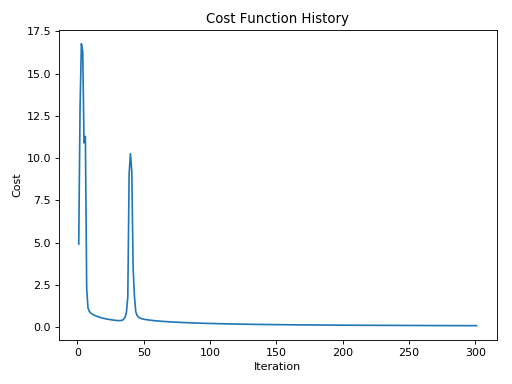

<IPython.core.display.Javascript object>


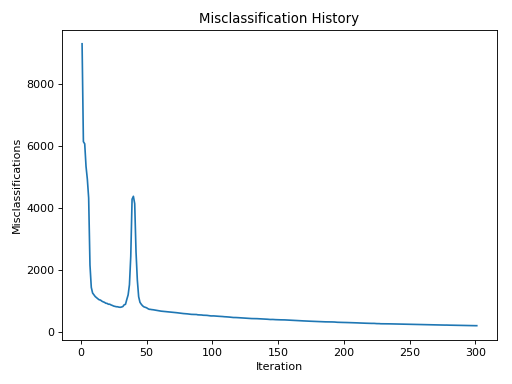

In [33]:
## Plot cost history
plt.figure()
plt.plot(np.linspace(1,iterations+1,iterations+1), costs)
plt.title("Cost Function History")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

## Plot misclassification history
plt.figure()
plt.plot(np.linspace(1,iterations+1,iterations+1), misclassified)
plt.title("Misclassification History")
plt.xlabel("Iteration")
plt.ylabel("Misclassifications")
plt.show()